In [1]:
from sklearn.feature_extraction.text import TfidfTransformer 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import normalize
from sklearn.utils.extmath import safe_sparse_dot
from sklearn.cluster import KMeans
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
from sklearn.metrics.cluster import adjusted_rand_score
from scipy.sparse.linalg import svds
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import inv
from scipy.spatial import cKDTree

from numpy.core.umath_tests import inner1d
from numpy.linalg import matrix_rank
import matplotlib.pyplot as plt
from mudata import MuData
import os.path as path
import seaborn as sns
import numexpr as ne
import pandas as pd
import scanpy as sc
import mudata as md
import numpy as np
import muon as mu
import anndata
import h5py
import time
import umap
import gc

/tmp/4634038.1.parallel.q/ipykernel_9489/1249493865.py:15: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/mnt/iusers01/fatpou01/bmh01/t48955xm/.conda/envs/maxxxxxxxin/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
import scib

In [2]:
from sklearn.metrics.cluster import normalized_mutual_info_score

In [3]:
from sklearn.metrics.cluster import adjusted_rand_score

In [4]:
from sklearn.metrics import silhouette_score

# pbmc-10k

In [12]:
celltype = pd.read_csv('./PBMC-Multiome10k/celltype.txt',sep='\t')

In [13]:
Mcluster = pd.read_table("./PBMC-Multiome10k/mojitoo_cluster.txt",sep=' ') 
M_embedding = pd.read_table("./PBMC-Multiome10k/mojitoo_embedding.txt",sep=' ') 

In [14]:
Scluster = pd.read_table("./PBMC-Multiome10k/seurat_cluster.txt",sep=' ') 
S_embedding = pd.read_table("./PBMC-Multiome10k/seurat_embedding.txt",sep=' ') 

In [15]:
mofa = md.read("/scratch/t48955xm/PBMC-Multiome10k/mofa.h5mu")

In [42]:
mdata = md.read("./PBMC-Multiome10k/pbmc10k.h5mu")

In [43]:
mdata

MuData object with n_obs × n_vars = 11787 × 114392
  obs:	'TriTan'
  var:	'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
  obsm:	'X_umap'
  2 modalities
    rna:	11787 x 14796
      var:	'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'hvg'
    atac:	11787 x 99596
      var:	'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'hvg'

In [45]:
adjusted_rand_score(celltype[['x']].values.T[0],Mcluster[['x']].T.values[0]),adjusted_rand_score(celltype[['x']].values.T[0],Scluster[['x']].T.values[0]),adjusted_rand_score(celltype[['x']].values.T[0],mofa.obs['leiden_joint'].values),adjusted_rand_score(celltype[['x']].values.T[0],mdata.obs['TriTan'].values)

(0.5496840985701015,
 0.6570041240620471,
 0.31617406641084667,
 0.7155657585214462)

In [47]:
normalized_mutual_info_score(celltype[['x']].values.T[0],Mcluster[['x']].T.values[0]),normalized_mutual_info_score(celltype[['x']].values.T[0],Scluster[['x']].T.values[0]),normalized_mutual_info_score(celltype[['x']].values.T[0],mofa.obs['leiden_joint'].values),normalized_mutual_info_score(celltype[['x']].values.T[0],mdata.obs['TriTan'].values)

(0.6911495523918534,
 0.7471182290508941,
 0.5910695602976105,
 0.7367138292894019)

In [22]:
silhouette_score(M_embedding, celltype[['x']].values.T[0]),silhouette_score(S_embedding, celltype[['x']].values.T[0]),silhouette_score(mofa.obsm['X_mofa'], celltype[['x']].values.T[0])

(0.08351753385332648, 0.40338693805053893, 0.11029349300537593)

In [77]:
plt.rcParams["figure.figsize"] = (4,4)

/tmp/4621694.1.parallel.q/ipykernel_11606/3152901247.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x, fontsize=20, rotation=30)
/tmp/4621694.1.parallel.q/ipykernel_11606/3152901247.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x, fontsize=20, rotation=30)
/tmp/4621694.1.parallel.q/ipykernel_11606/3152901247.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x, fontsize=20, rotation=30)


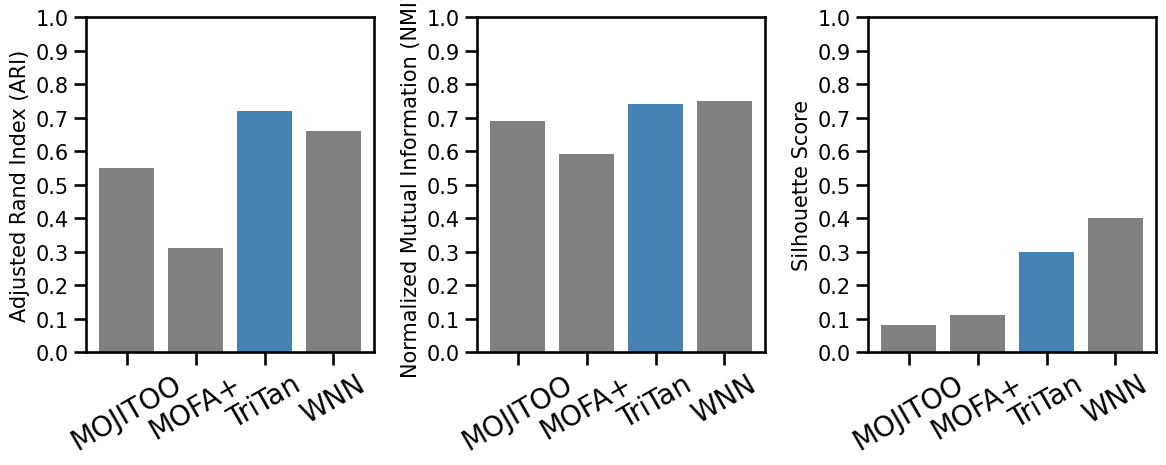

In [151]:
# Data for the different plots
x = np.array(["MOJITOO","MOFA+","TriTan","WNN"])
y1 = np.array([0.55, 0.31, 0.72, 0.66])  # Data for the first plot
y2 = np.array([0.69, 0.59, 0.74, 0.75])  # Data for the second plot
y3 = np.array([0.08, 0.11, 0.30, 0.40])  # Data for the third plot

# Labels for the y-axis of each plot
y_labels = ["Adjusted Rand Index (ARI)", "Normalized Mutual Information (NMI)", "Silhouette Score"]

# Creating the subplots
fig, axs = plt.subplots(1, 3, figsize=(12,5))
#fig.suptitle("PBMC-10K", fontsize=20)
# Plotting each subplot with different data and y-axis label
for i, ax in enumerate(axs):
    if i == 0:
        y = y1
    elif i == 1:
        y = y2
    else:
        y = y3

    ax.bar(x, y, color=colors, width=0.8)
    
    ax.set_ylabel(y_labels[i], fontsize=15)
    ax.set_xticklabels(x, fontsize=20, rotation=30)
    ax.set_yticks(np.arange(0, 1.1, 0.1))
    ax.set_yticklabels(np.round(np.arange(0, 1.1, 0.1), 1), fontsize=15)
    ax.grid(False)

plt.tight_layout()
plt.show()
fig.savefig("./PBMC-Multiome10k/metrics.png", dpi=750, bbox_inches = 'tight')


# share-seq

In [97]:
celltype = pd.read_csv('./GSM4156597/GSM4156597_skin_celltype.txt',sep='\t')

In [68]:
mdata = md.read("./GSM4156597/share_seq_tp_mudata_hvg.h5mu")

In [31]:
from TriTan import TriTan

In [117]:
svd=np.array([50,300,50,300])

In [118]:
tritan= TriTan.TriTan(res_size = 100, n_component= svd)

In [119]:
tritan.fit(mdata)

/mnt/iusers01/fatpou01/bmh01/t48955xm/.conda/envs/maxxxxxxxin/lib/python3.9/site-packages/TriTan/TriTan.py:179: RuntimeWarning: invalid value encountered in divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))
/mnt/iusers01/fatpou01/bmh01/t48955xm/.conda/envs/maxxxxxxxin/lib/python3.9/site-packages/TriTan/TriTan.py:179: RuntimeWarning: invalid value encountered in divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


In [120]:
tritan.F.shape

(34774, 34)

In [121]:
group1 = np.argmax(tritan.F.T, axis =0)

In [98]:
Mcluster = pd.read_table("./GSM4156597/mojitoo_cluster.txt",sep=' ') 
M_embedding = pd.read_table("./GSM4156597/mojitoo_embedding.txt",sep=' ') 

In [99]:
Scluster = pd.read_table("./GSM4156597/seurat_cluster.txt",sep=' ') 
S_embedding = pd.read_table("./GSM4156597/seurat_embedding.txt",sep=' ') 

In [112]:
mofa = md.read("/scratch/t48955xm/GSM4156597/mofa.h5mu")

In [129]:
sc.pp.neighbors(mofa, use_rep="X_mofa")
sc.tl.leiden(mofa, key_added='leiden_joint')

In [130]:
adjusted_rand_score(celltype[['celltype']].values.T[0],Mcluster[['x']].T.values[0]),adjusted_rand_score(celltype[['celltype']].values.T[0],Scluster[['x']].T.values[0]),adjusted_rand_score(celltype[['celltype']].values.T[0],mofa.obs['leiden_joint'].values),adjusted_rand_score(celltype[['celltype']].values.T[0],group1)

(0.4158292293591125,
 0.39950178922686475,
 0.2206309060290268,
 0.4258438286202122)

In [131]:
normalized_mutual_info_score(celltype[['celltype']].values.T[0],Mcluster[['x']].T.values[0]),normalized_mutual_info_score(celltype[['celltype']].values.T[0],Scluster[['x']].T.values[0]),normalized_mutual_info_score(celltype[['celltype']].values.T[0],mofa.obs['leiden_joint'].values),normalized_mutual_info_score(celltype[['celltype']].values.T[0],group1)

(0.5812974191433956, 0.6022142318977713, 0.477655006511482, 0.590292167662854)

In [133]:
silhouette_score(M_embedding, celltype[['celltype']].values.T[0]),silhouette_score(S_embedding, celltype[['celltype']].values.T[0]),silhouette_score(mofa.obsm['X_mofa'], celltype[['celltype']].values.T[0]),silhouette_score(tritan.embedding, celltype[['celltype']].values.T[0])

(0.04974466363355876, 0.08707478373728136, 0.012679830741040739, 0.069921516)

/tmp/4621694.1.parallel.q/ipykernel_11606/1346948883.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x, fontsize=20, rotation=30)
/tmp/4621694.1.parallel.q/ipykernel_11606/1346948883.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x, fontsize=20, rotation=30)
/tmp/4621694.1.parallel.q/ipykernel_11606/1346948883.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x, fontsize=20, rotation=30)


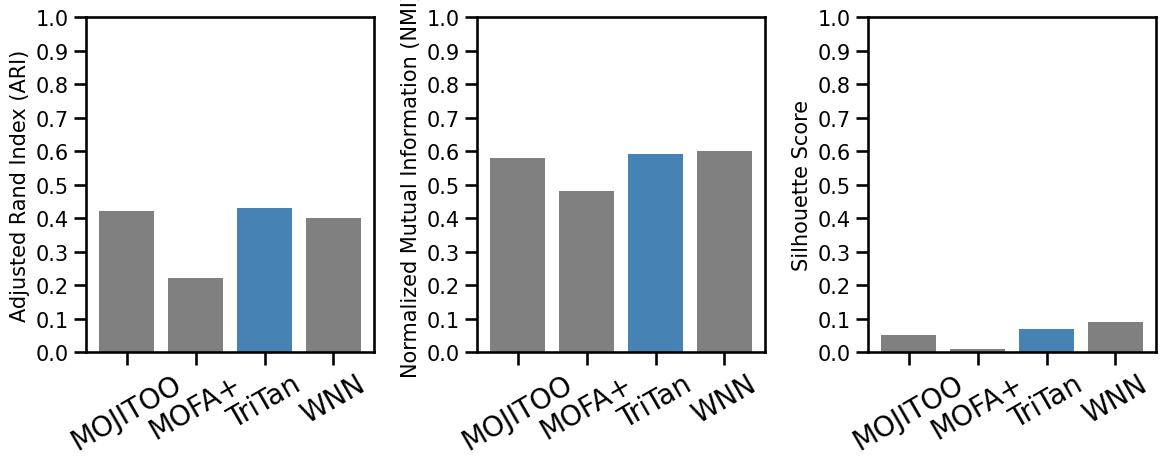

In [152]:
# Data for the different plots
x = np.array(["MOJITOO","MOFA+","TriTan","WNN"])
y1 = np.array([0.42,0.22, 0.43,  0.40])  # Data for the first plot
y2 = np.array([0.58, 0.48, 0.59, 0.60])  # Data for the second plot
y3 = np.array([0.05, 0.01, 0.07, 0.09])  # Data for the third plot

# Labels for the y-axis of each plot
y_labels = ["Adjusted Rand Index (ARI)", "Normalized Mutual Information (NMI)", "Silhouette Score"]

# Creating the subplots
fig, axs = plt.subplots(1, 3, figsize=(12,5))
#fig.suptitle("Skin-share", fontsize=40)
# Plotting each subplot with different data and y-axis label
for i, ax in enumerate(axs):
    if i == 0:
        y = y1
    elif i == 1:
        y = y2
    else:
        y = y3

    ax.bar(x, y, color=colors, width=0.8)
    
    ax.set_ylabel(y_labels[i], fontsize=15)
    ax.set_xticklabels(x, fontsize=20, rotation=30)
    ax.set_yticks(np.arange(0, 1.1, 0.1))
    ax.set_yticklabels(np.round(np.arange(0, 1.1, 0.1), 1), fontsize=15)
    ax.grid(False)

plt.tight_layout()
plt.show()
fig.savefig("./GSM4156597/metrics.png", dpi=750, bbox_inches = 'tight')

# Neurips

In [44]:
mdata = sc.read_h5ad("/scratch/t48955xm/GSE194122/GSE194122_tp_mudata_hvg.h5mu")

In [46]:
celltype = mdata.obs['cell_type']

In [21]:
from sklearn.utils.extmath import randomized_svd

In [22]:
%%time
u_rna, s_rna, v_rna = randomized_svd(X_gene,n_components=300, random_state=0)

CPU times: user 5min 38s, sys: 12.9 s, total: 5min 51s
Wall time: 1min 26s


In [23]:
%%time
u_atac, s_atac, v_atac = randomized_svd(X_atac,n_components=300, random_state=0)

CPU times: user 45min 3s, sys: 38.7 s, total: 45min 42s
Wall time: 11min 26s


In [33]:
rna=[u_rna,v_rna]
atac=[u_atac,v_atac]
svd=[50,300,50,300]

In [34]:
tritan = TriTan.TriTan(n_component=svd,precomputed=True,svd_rna=rna,svd_atac=atac,res_size=120,resolution=10)

In [35]:
tritan.fit(mdata)

/mnt/iusers01/fatpou01/bmh01/t48955xm/.conda/envs/maxxxxxxxin/lib/python3.9/site-packages/TriTan/TriTan.py:179: RuntimeWarning: invalid value encountered in divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))
/mnt/iusers01/fatpou01/bmh01/t48955xm/.conda/envs/maxxxxxxxin/lib/python3.9/site-packages/TriTan/TriTan.py:179: RuntimeWarning: invalid value encountered in divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))


In [50]:
group1 = np.argmax(tritan.F.T, axis =0)

In [36]:
mofa = md.read("/scratch/t48955xm/GSE194122/mofa.h5mu")

In [37]:
sc.pp.neighbors(mofa, use_rep="X_mofa")
sc.tl.leiden(mofa, key_added='leiden_joint')

In [39]:
Mcluster = pd.read_table("/scratch/t48955xm/GSE194122/mojitoo_cluster.txt",sep=' ') 
M_embedding = pd.read_table("/scratch/t48955xm/GSE194122/mojitoo_embedding.txt",sep=' ')

In [40]:
Scluster = pd.read_table("/scratch/t48955xm/GSE194122/seurat_cluster.txt",sep=' ') 
S_embedding = pd.read_table("/scratch/t48955xm/GSE194122/seurat_embedding.txt",sep=' ') 

In [51]:
adjusted_rand_score(celltype.values,Mcluster[['x']].T.values[0]),adjusted_rand_score(celltype.values,Scluster[['x']].T.values[0]),adjusted_rand_score(celltype.values,mofa.obs['leiden_joint'].values),adjusted_rand_score(celltype.values,group1)

(0.5788857860135768, 0.358494741239178, 0.3060809285200817, 0.4269069772439976)

In [53]:
normalized_mutual_info_score(celltype.values,Mcluster[['x']].T.values[0]),normalized_mutual_info_score(celltype.values,Scluster[['x']].T.values[0]),normalized_mutual_info_score(celltype.values,mofa.obs['leiden_joint'].values),normalized_mutual_info_score(celltype.values,group1)

(0.7124108870405946,
 0.6740905445387315,
 0.6096300799023323,
 0.6464688304506316)

In [54]:
silhouette_score(M_embedding, celltype.values),silhouette_score(S_embedding, celltype.values),silhouette_score(mofa.obsm['X_mofa'], celltype.values),silhouette_score(tritan.embedding, celltype.values)

(0.022543661201586202, 0.16692230133844316, 0.03466144116774207, 0.09622194)

/tmp/4634038.1.parallel.q/ipykernel_9489/2053078577.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x, fontsize=20, rotation=30)
/tmp/4634038.1.parallel.q/ipykernel_9489/2053078577.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x, fontsize=20, rotation=30)
/tmp/4634038.1.parallel.q/ipykernel_9489/2053078577.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x, fontsize=20, rotation=30)


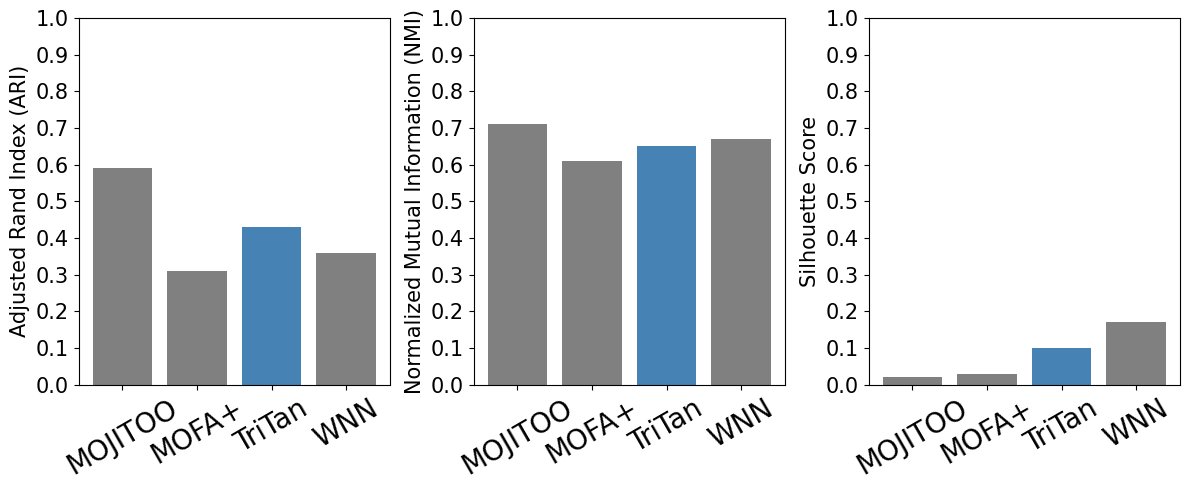

In [58]:
# Data for the different plots
x = np.array(["MOJITOO","MOFA+","TriTan","WNN"])
y1 = np.array([0.59,0.31, 0.43,  0.36])  # Data for the first plot
y2 = np.array([0.71, 0.61, 0.65, 0.67])  # Data for the second plot
y3 = np.array([0.02, 0.03, 0.1, 0.17])  # Data for the third plot

# Labels for the y-axis of each plot
y_labels = ["Adjusted Rand Index (ARI)", "Normalized Mutual Information (NMI)", "Silhouette Score"]

# Creating the subplots
fig, axs = plt.subplots(1, 3, figsize=(12,5))
#fig.suptitle("Skin-share", fontsize=40)
# Plotting each subplot with different data and y-axis label
for i, ax in enumerate(axs):
    if i == 0:
        y = y1
    elif i == 1:
        y = y2
    else:
        y = y3

    ax.bar(x, y, color=["grey","grey","steelblue","grey"], width=0.8)
    
    ax.set_ylabel(y_labels[i], fontsize=15)
    ax.set_xticklabels(x, fontsize=20, rotation=30)
    ax.set_yticks(np.arange(0, 1.1, 0.1))
    ax.set_yticklabels(np.round(np.arange(0, 1.1, 0.1), 1), fontsize=15)
    ax.grid(False)

plt.tight_layout()
plt.show()
fig.savefig("/scratch/t48955xm/GSE194122/metrics.png", dpi=750, bbox_inches = 'tight')

### stablity

In [59]:
mdata = md.read("./PBMC-Multiome10k/pbmc10k.h5mu")

In [60]:
celltype = pd.read_csv('./PBMC-Multiome10k/celltype.txt',sep='\t')

In [61]:
ans = []

In [62]:
for i in range(10):
    tritan= TriTan.TriTan()
    tritan.fit(mdata)
    group1 = np.argmax(tritan.F.T, axis =0)
    ans.append([adjusted_rand_score(celltype[['x']].values.T[0],group1),normalized_mutual_info_score(celltype[['x']].values.T[0],group1),silhouette_score(tritan.embedding, celltype[['x']].values.T[0])])

/mnt/iusers01/fatpou01/bmh01/t48955xm/.conda/envs/maxxxxxxxin/lib/python3.9/site-packages/TriTan/TriTan.py:179: RuntimeWarning: invalid value encountered in divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))
/mnt/iusers01/fatpou01/bmh01/t48955xm/.conda/envs/maxxxxxxxin/lib/python3.9/site-packages/TriTan/TriTan.py:179: RuntimeWarning: invalid value encountered in divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))
/mnt/iusers01/fatpou01/bmh01/t48955xm/.conda/envs/maxxxxxxxin/lib/python3.9/site-packages/TriTan/TriTan.py:179: RuntimeWarning: invalid value encountered in divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))
/mnt/iusers01/fatpou01/bmh01/t48955xm/.conda/envs/maxxxxxxxin/lib/python3.9/site-packages/TriTan/TriTan.py:179: RuntimeWarning: invalid value encountered in divide
  result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))
/mnt/iusers01/fatpou01/bmh01/t48955xm/.conda/envs/ma

In [65]:
ans = np.array(ans)

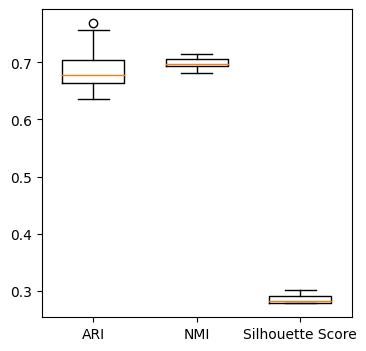

In [79]:
import matplotlib.pyplot as plt

y1 = ans[:,0]
y2 = ans[:,1]
y3 = ans[:,2]
#plt.title('Time',fontsize=20)  # 折线图标题
#plt.xlabel('Number of cells',fontsize=15)  # x轴标题
#plt.ylabel('Time-log10(seconds)',fontsize=15)  # y轴标题
plt.boxplot([y1, y2, y3], positions=[1, 2, 3], widths=0.6)

# Setting the x-axis tick labels
plt.xticks([1, 2, 3], ['ARI', 'NMI', 'Silhouette Score'])

plt.savefig("./PBMC-Multiome10k/stable.png", dpi=750, bbox_inches = 'tight')